In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import random  # Import random for selecting random indices

# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
# Define dataset directories
TRAIN_DIR = 'train/'  # Update these paths as needed
TEST_DIR = 'test/'

In [6]:

# Function to load dataset
def load_dataset(directory):
    image_paths = []
    labels = []
    if not os.path.exists(directory):
        print(f"Error: Directory {directory} does not exist.")
        return [], []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels.append(label)
            print(f"Completed loading label: {label}")
    return image_paths, labels


In [8]:

# Load training dataset
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)


Completed loading label: angry
Completed loading label: disgust
Completed loading label: fear
Completed loading label: happy
Completed loading label: neutral
Completed loading label: sad
Completed loading label: surprise


In [10]:

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
print("Training Data:")
print(train.head())


Training Data:
                                  image     label
0   train/neutral\Training_51179771.jpg   neutral
1     train/happy\Training_35140063.jpg     happy
2  train/surprise\Training_76711640.jpg  surprise
3     train/happy\Training_54541966.jpg     happy
4     train/angry\Training_40281128.jpg     angry


In [12]:

# Load testing dataset
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
print("Testing Data:")
print(test.head())


Completed loading label: angry
Completed loading label: disgust
Completed loading label: fear
Completed loading label: happy
Completed loading label: neutral
Completed loading label: sad
Completed loading label: surprise
Testing Data:
                                 image  label
0  test/angry\PrivateTest_10131363.jpg  angry
1  test/angry\PrivateTest_10304478.jpg  angry
2   test/angry\PrivateTest_1054527.jpg  angry
3  test/angry\PrivateTest_10590091.jpg  angry
4   test/angry\PrivateTest_1109992.jpg  angry


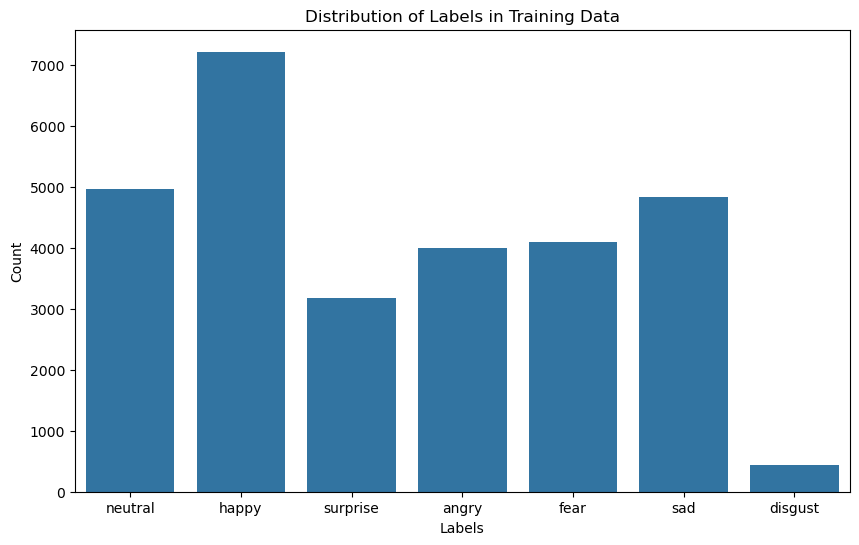

In [14]:

# Plot label distribution for training data
plt.figure(figsize=(10, 6))
sns.countplot(x=train['label'])
plt.title("Distribution of Labels in Training Data")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


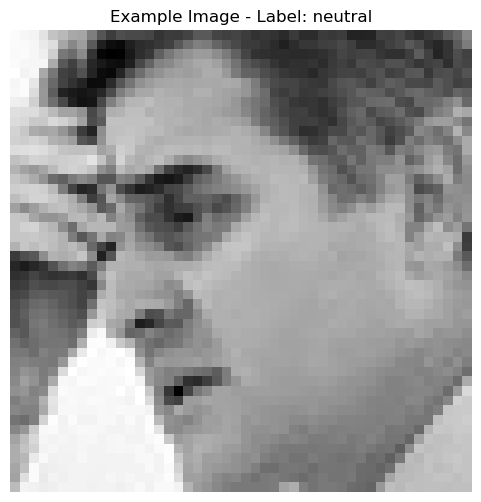

In [16]:

# Load and display a single image
if len(train) > 0:
    img = Image.open(train['image'][0])
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Example Image - Label: {train['label'][0]}")
    plt.axis('off')
    plt.show()


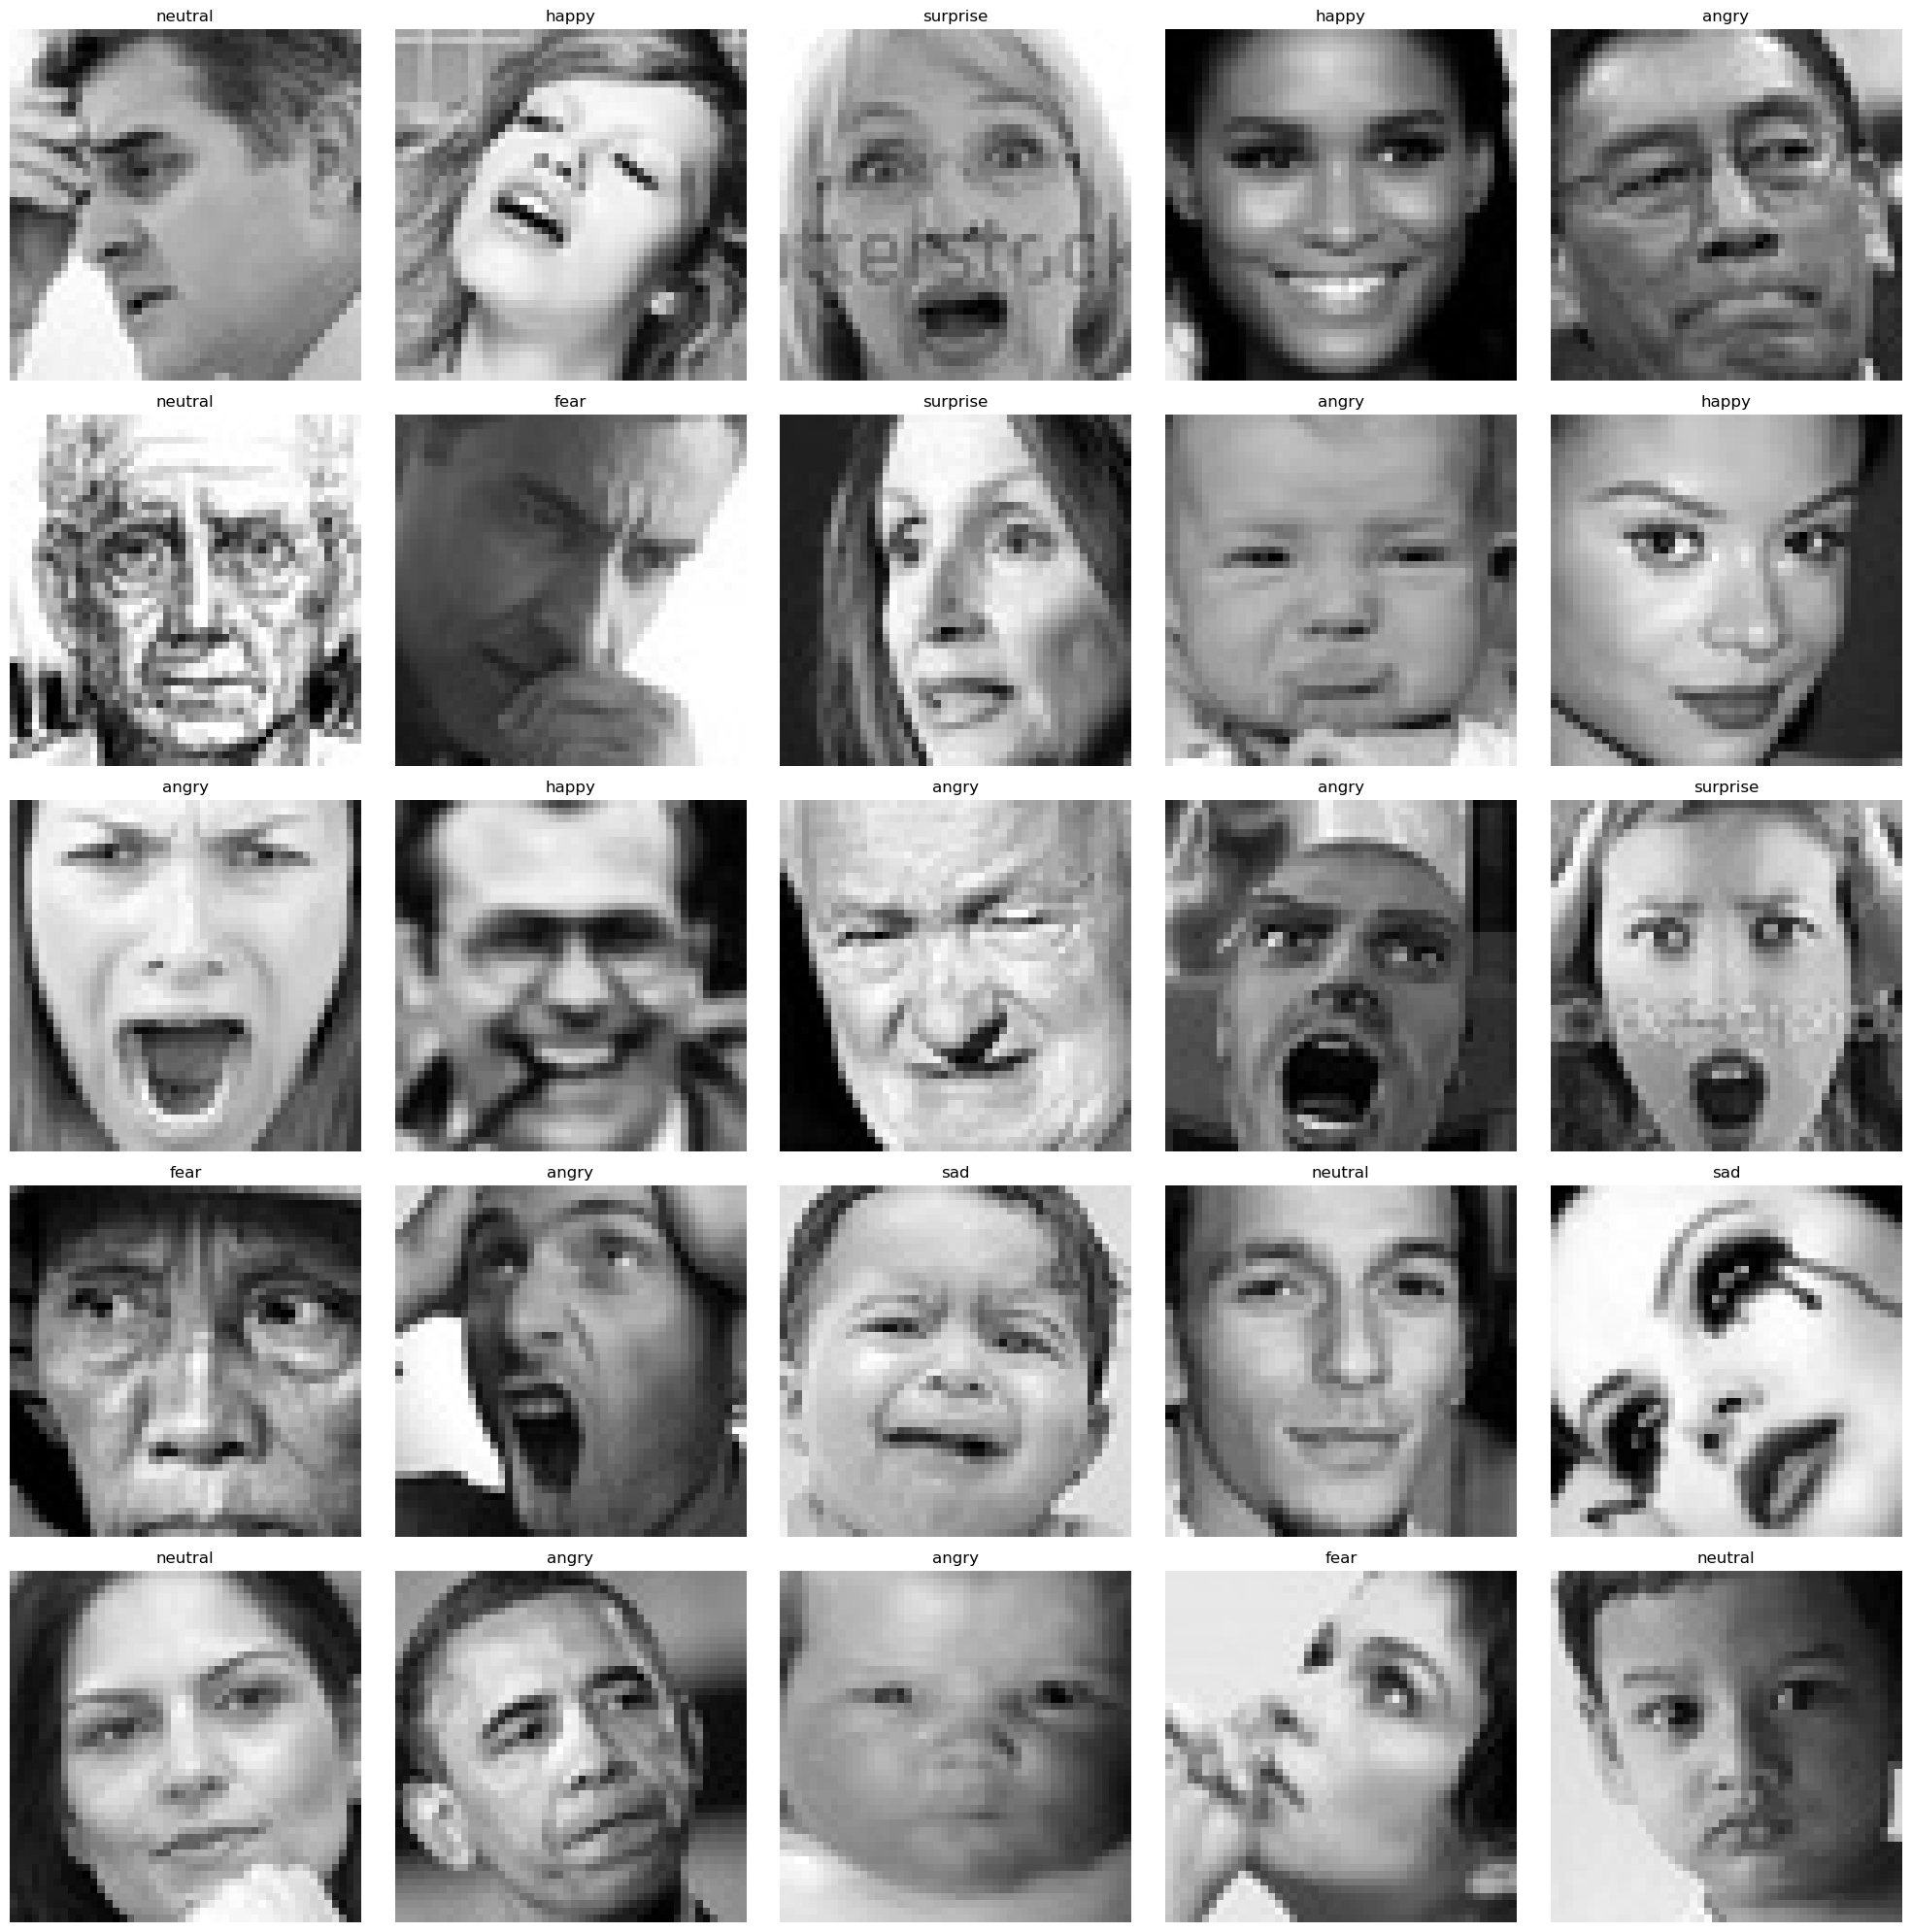

In [18]:

# Display a grid of images
plt.figure(figsize=(20, 20))
files = train.iloc[:25]

for i, (file, label) in enumerate(zip(files['image'], files['label'])):
    plt.subplot(5, 5, i + 1)
    img = load_img(file, color_mode="grayscale")
    img = np.array(img)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:

# Feature extraction function
def extract_features(images):
    features = []
    for image in tqdm(images, desc="Extracting Features"):
        img = load_img(image, color_mode="grayscale", target_size=(48, 48))  # Ensure consistent size
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)  # Reshape for CNN input
    return features


In [22]:
# Extract features for training and testing datasets
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])


Extracting Features:   0%|          | 0/28709 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/7178 [00:00<?, ?it/s]

In [25]:


# Normalize the images
x_train = train_features / 255.0
x_test = test_features / 255.0


In [27]:

# Encode labels
le = LabelEncoder()
le.fit(train['label'])

y_train = le.transform(train['label'])
y_test = le.transform(test['label'])


In [29]:

# Convert labels to one-hot encoding
num_classes = len(le.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [31]:

# Display one-hot encoded label for first training sample
print("Example One-Hot Encoded Label:", y_train[0])

Example One-Hot Encoded Label: [0. 0. 0. 0. 1. 0. 0.]


In [33]:


# Model configuration
input_shape = (48, 48, 1)
output_class = num_classes
print(f"Input Shape: {input_shape}, Number of Classes: {output_class}")


Input Shape: (48, 48, 1), Number of Classes: 7


In [35]:
# Model creation
model = Sequential()
# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

In [37]:


# Output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:

# Train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.2436 - loss: 1.8360 - val_accuracy: 0.2471 - val_loss: 1.8124
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.2513 - loss: 1.8101 - val_accuracy: 0.2699 - val_loss: 1.7450
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.2917 - loss: 1.7291 - val_accuracy: 0.3873 - val_loss: 1.5660
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.3693 - loss: 1.5961 - val_accuracy: 0.4497 - val_loss: 1.4244
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.4285 - loss: 1.4815 - val_accuracy: 0.4528 - val_loss: 1.4021
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.4543 - loss: 1.4059 - val_accuracy: 0.4889 - val_loss: 1.3206
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.4694 - loss: 1.3779 - val_accuracy: 0.5074 - val_loss: 1.2669
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.4860 - loss: 1.3357 - val_accu

In [49]:
#tested by shu

In [52]:
# Display accuracy in percentage
train_accuracy = history.history['accuracy'][-1] * 100
val_accuracy = history.history['val_accuracy'][-1] * 100

In [54]:

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Training Accuracy: 50.66%
Validation Accuracy: 55.14%


In [56]:



# Save Model
model_json = model.to_json()
with open("Emotion-model.json", "w") as json_file:
    json_file.write(model_json)


In [58]:
model.save_weights("FacialExpression_weights.weights.h5")
print("Model saved successfully!")


Model saved successfully!


In [60]:
#end tested  by shu

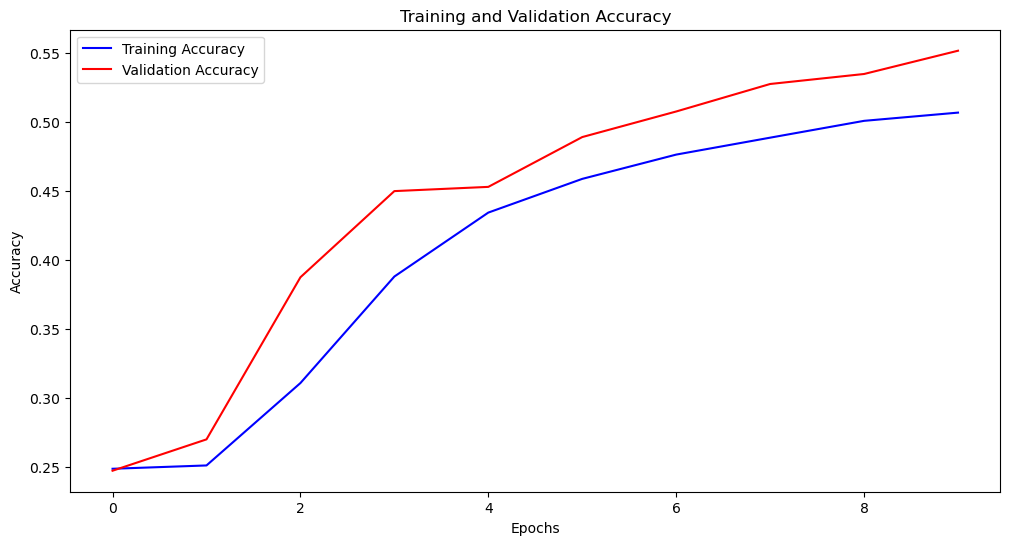

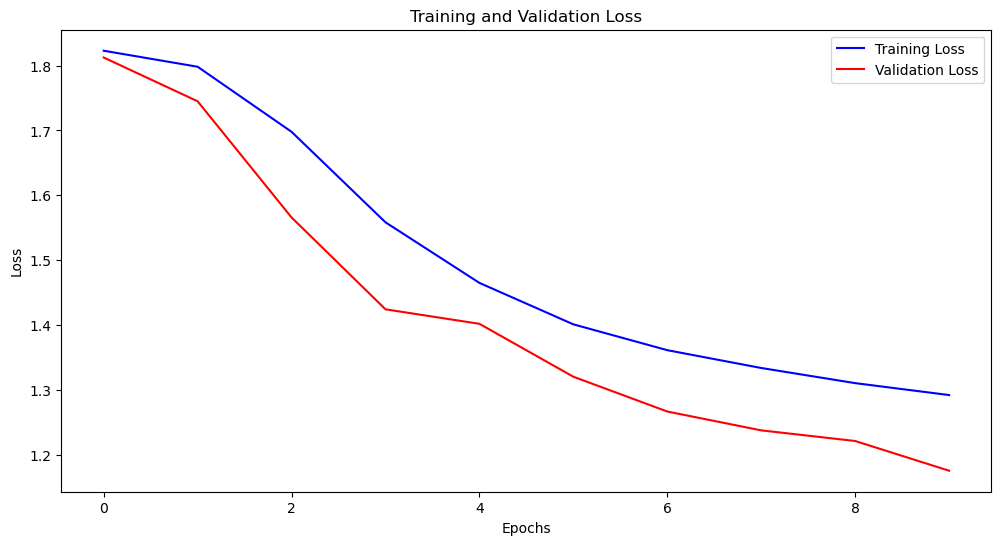

In [62]:

# Visualize Training Metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()





Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Predicted Output: angry


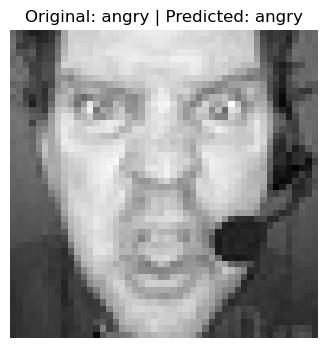

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Output: happy


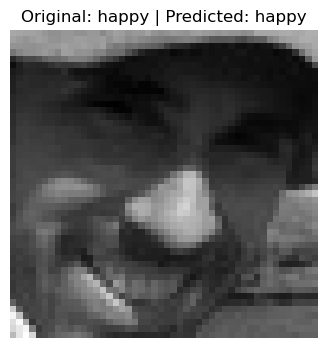

In [64]:
# Test with image data
def test_with_random_image(test, x_test, model, label_encoder):
    """
    Test the model with a random image from the test dataset.
    Args:
        test (DataFrame): Test dataframe containing image paths and labels.
        x_test (numpy.ndarray): Preprocessed test features.
        model (keras.Model): Trained model.
        label_encoder (LabelEncoder): Encoder used for label transformation.
    """
    # Select a random image index
    image_index = random.randint(0, len(test) - 1)
    
    # Print the original label
    original_label = test['label'][image_index]
    print(f"Original Output: {original_label}")
    
    # Predict the label for the image
    image_features = x_test[image_index].reshape(1, 48, 48, 1)  # Reshape for prediction
    pred = model.predict(image_features)
    predicted_label = label_encoder.inverse_transform([pred.argmax()])[0]
    print(f"Predicted Output: {predicted_label}")
    
    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')
    plt.title(f"Original: {original_label} | Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Call the test function for a random image
test_with_random_image(test, x_test, model, le)

# Test another random image
test_with_random_image(test, x_test, model, le)

Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Output: surprise


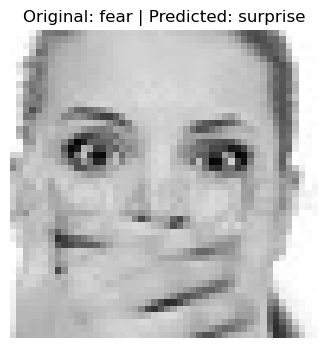

In [66]:
test_with_random_image(test, x_test, model, le)

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Output: happy


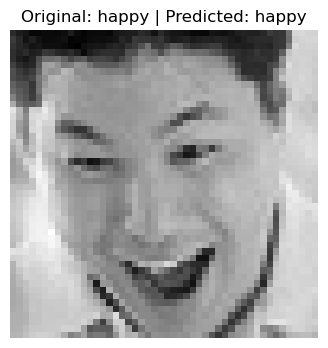

In [68]:
test_with_random_image(test, x_test, model, le)

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Output: happy


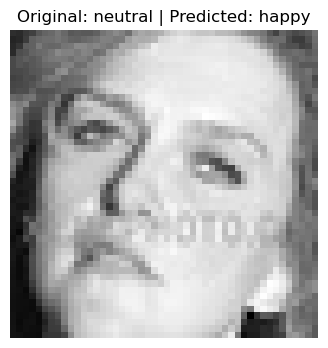

In [70]:
test_with_random_image(test, x_test, model, le)

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted Output: neutral


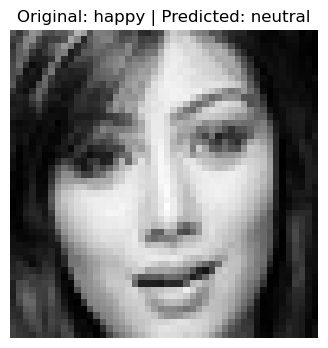

In [72]:
test_with_random_image(test, x_test, model, le)

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Output: neutral


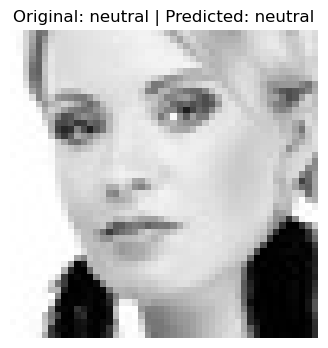

In [74]:
test_with_random_image(test, x_test, model, le)

Original Output: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Output: angry


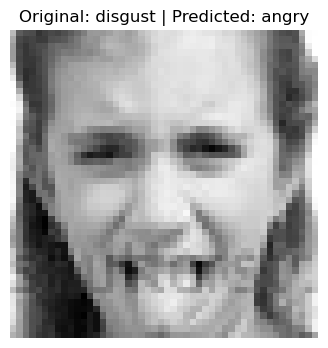

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Output: happy


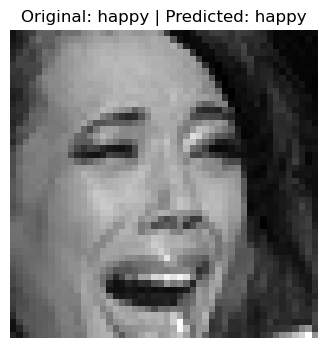

Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Output: sad


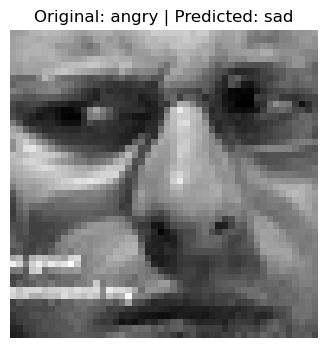

Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Output: sad


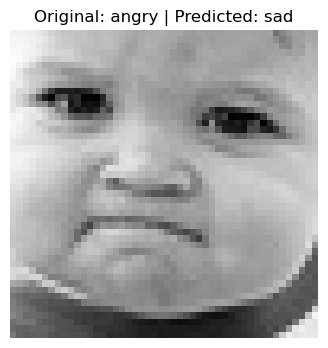

In [76]:
test_with_random_image(test, x_test, model, le)
test_with_random_image(test, x_test, model, le)
test_with_random_image(test, x_test, model, le)
test_with_random_image(test, x_test, model, le)

Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Output: angry


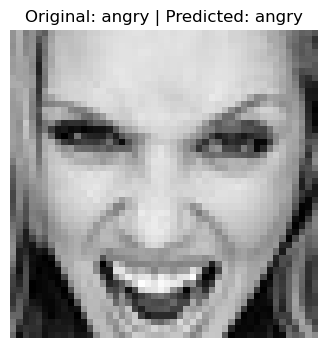

In [78]:
test_with_random_image(test, x_test, model, le)

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted Output: surprise


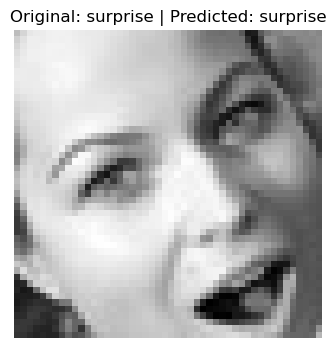

In [80]:
test_with_random_image(test, x_test, model, le)

Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted Output: fear


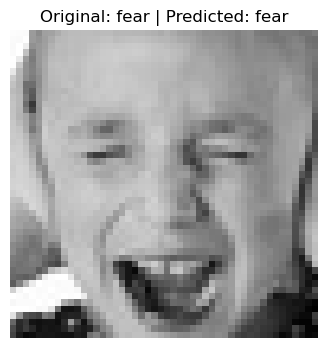

In [82]:
test_with_random_image(test, x_test, model, le)

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted Output: happy


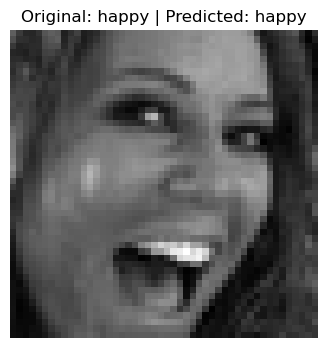

In [84]:
test_with_random_image(test, x_test, model, le)

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted Output: happy


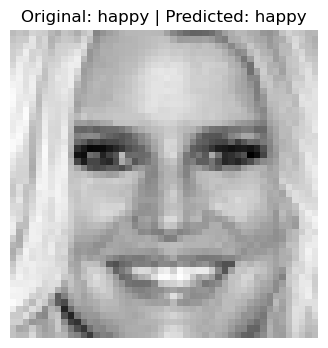

In [86]:
test_with_random_image(test, x_test, model, le)

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted Output: fear


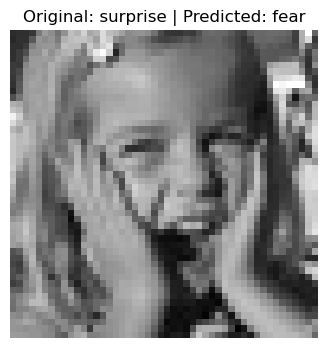

In [72]:
test_with_random_image(test, x_test, model, le)

Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted Output: surprise


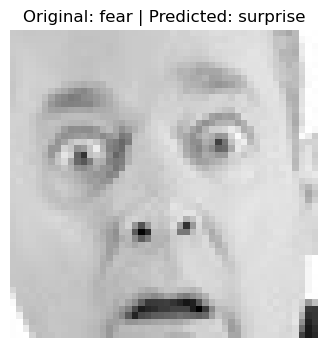

In [74]:
test_with_random_image(test, x_test, model, le)

Original Output: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Output: sad


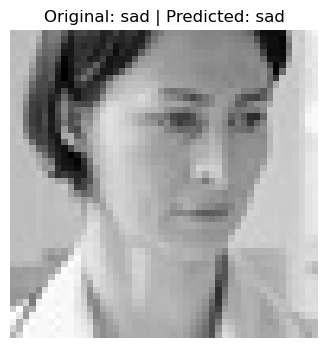

In [76]:
test_with_random_image(test, x_test, model, le)

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted Output: neutral


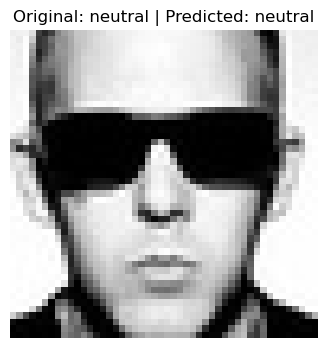

In [78]:
test_with_random_image(test, x_test, model, le)